In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from skimage.transform import resize
from matplotlib import image 

In [2]:
cd dataset_small

/Users/pranjalgupta/Documents/Domain Adaption 2020/dataset_small


In [3]:
#importing resized numpy arrays
a = np.load('train_in.npz')
train_in = a['arr_0']
print(train_in.size)
b = np.load('train_target.npz')
train_target = b['arr_0']
print(train_target.size)
c = np.load('validation_in.npz')
validation_in = c['arr_0']
print(validation_in.size)
d = np.load('validation_target.npz')
validation_target = d['arr_0']
print(validation_target.size)

1440000000
12000
576000000
4800


In [3]:
#importing resized numpy arrays
a = np.load('syn_resout_pool.npz')
syn_mid = a['arr_0']
print(syn_mid.size)
b = np.load('train_target.npz')
train_target = b['arr_0']
c = np.load('real_resout_pool.npz')
real_mid = c['arr_0']
d = np.load('validation_target.npz')
validation_target = d['arr_0']

9830400


In [4]:
#xd = []
xe = []
for i in [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000]:
    for j in range(0+i,400+i):
        #xd.append(train_in[j])
        xe.append(i/1000)
#small_train_in = np.array(xd)
small_train_target = np.array(xe)
small_train_target.shape

(4800,)

In [5]:
'''from sklearn.utils import shuffle
syn_input, tar = shuffle(small_train_in,small_train_target)
real_input, tar1 = shuffle(validation_in, validation_target)
syn_target = tf.one_hot(tar, depth=12)s
real_target = tf.one_hot(tar1, depth=12)
print(syn_input.shape, syn_target.shape)'''

'from sklearn.utils import shuffle\nsyn_input, tar = shuffle(small_train_in,small_train_target)\nreal_input, tar1 = shuffle(validation_in, validation_target)\nsyn_target = tf.one_hot(tar, depth=12)\nreal_target = tf.one_hot(tar1, depth=12)\nprint(syn_input.shape, syn_target.shape)'

In [6]:
#small_train_in, validation_in, small_train_target, validation_target

In [7]:
validation_in_large = validation_in*255.0

In [8]:
def preprocess(x):
    x = x * 255.0
    y = tf.keras.applications.resnet.preprocess_input(x)
    return y/255.0

In [9]:
pr_syn_input = preprocess(small_train_in)

In [10]:
pr_real_input = preprocess(validation_in_large)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


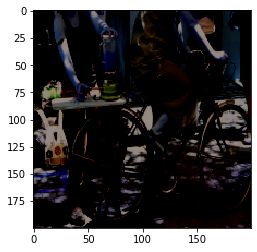

In [17]:
plt.imshow(pr_real_input[497])

In [13]:
feature_extractor = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(200,200,3), pooling='avg')

In [15]:
def generate_features(x):
    mid_pred = feature_extractor.predict(x)
    #reshaped_mid_pred = np.reshape(mid_pred, (-1, 7*7*2048))
    return mid_pred

In [18]:
syn_mid = generate_features(pr_syn_input)  # Source Domain features. 

In [20]:
real_mid = generate_features(pr_real_input) # Target Domain Features. 

In [19]:
#save
np.savez_compressed('syn_resout_pool.npz', syn_mid)

In [21]:
np.savez_compressed('real_resout_pool.npz', real_mid)

In [5]:
syn_target = tf.one_hot(small_train_target, depth=12)
real_target = tf.one_hot(validation_target, depth=12)

In [6]:
source_dataset = tf.data.Dataset.from_tensor_slices((syn_mid, syn_target)).shuffle(400).batch(64)

In [7]:
da_dataset = tf.data.Dataset.from_tensor_slices((syn_mid, syn_target, real_mid, real_target)).shuffle(400).batch(32)
test_dataset2 = tf.data.Dataset.from_tensor_slices((real_mid, real_target)).shuffle(400).batch(64) #Test Dataset over Target (used for training)

In [8]:
@tf.custom_gradient
def gradient_layer(x, lamda=1.0):
    y = tf.identity(x)
    def grad(dy):
        return lamda*-dy, None
    return y, grad

In [9]:
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x, lamda=1.0):
        return gradient_layer(x, lamda)

In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, MaxPool2D, Dense, Flatten

In [31]:
class DANN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.feature_extractor_layer = Dense(1024, activation='relu')
        
        self.label_predictor_layer2 = Dense(12, activation=None)
        
        self.domain_predictor_layer0 = GradientReversalLayer()
        self.domain_predictor_layer2 = Dense(2, activation=None)
        
    def call(self, x, train=False, source_train=True, lamda=1.0):
        
        x = self.feature_extractor_layer(x)
        
        
        #Label Predictor
        if source_train is True:
            feature_slice = x
        else:
            feature_slice = tf.slice(x, [0, 0], [x.shape[0] // 2, -1])
        
        l_logits = self.label_predictor_layer2(feature_slice)
        
        #Domain Predictor
        if source_train is True:
            return l_logits
        else:
            dp_x = self.domain_predictor_layer0(x, lamda)    #GradientReversalLayer
            d_logits = self.domain_predictor_layer2(dp_x)
            
            return l_logits, d_logits

In [32]:
model = DANN()

In [33]:
def loss_func(input_logits, target_labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=input_logits, labels=target_labels))

def get_loss(l_logits, labels, d_logits=None, domain=None):
    if d_logits is None:
        return loss_func(l_logits, labels)
    else:
        return loss_func(l_logits, labels) + loss_func(d_logits, domain)

model_optimizer = tf.optimizers.SGD()

In [34]:
domain_labels = np.vstack([np.tile([1., 0.], [32, 1]),
                           np.tile([0., 1.], [32, 1])])
domain_labels = domain_labels.astype('float32')

In [35]:
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
source_acc = []  # Source Domain Accuracy while Source-only Training
da_acc = []      # Source Domain Accuracy while DA-training
test2_acc = []   # Target Domain (used for Training) Accuracy

In [36]:
@tf.function
def train_step_source(s_images, s_labels, lamda=1.0):
    images = s_images
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=True, lamda=lamda)
        
        model_loss = get_loss(output, labels)
        epoch_accuracy(output, labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))

In [37]:
@tf.function
def train_step_da(s_images, s_labels, t_images=None, t_labels=None, lamda=1.0):
    images = tf.concat([s_images, t_images], 0)
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=False, lamda=lamda)
        
        model_loss = get_loss(output[0], labels, output[1], domain_labels)
        epoch_accuracy(output[0], labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))

In [38]:
@tf.function
def test_step(t_images, t_labels):
    images = t_images
    labels = t_labels
    
    output = model(images, train=False, source_train=True)
    epoch_accuracy(output, labels)

In [39]:
def train(train_mode, epochs):
    
    if train_mode == 'source':
        dataset = source_dataset
        train_func = train_step_source
        acc_list = source_acc
    elif train_mode == 'domain-adaptation':
        dataset = da_dataset
        train_func = train_step_da
        acc_list = da_acc
    else:
        raise ValueError("Unknown training Mode")
    
    for epoch in range(epochs):
        p = float(epoch) / epochs
        lamda = (2 / (1 + np.exp(-100 * p, dtype=np.float32))) - 1
        lamda = lamda.astype('float32')

        for batch in dataset:
            train_func(*batch, lamda=lamda)
        
        print("Training: Epoch {} :\t Source Accuracy : {:.3%}".format(epoch, epoch_accuracy.result()))
        acc_list.append(epoch_accuracy.result())
        test()
        epoch_accuracy.reset_states()

In [40]:
def test():
    epoch_accuracy.reset_states()
    
    '''#Testing Dataset (Target Domain)
    for batch in test_dataset:
        test_step(*batch)
        
    print("Testing Accuracy : {:.3%}".format(epoch_accuracy.result()), end='  |  ')
    test_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()'''
    
    #Target Domain (used for Training)
    for batch in test_dataset2:
        test_step(*batch)
    
    print("Target Domain Accuracy : {:.3%}".format(epoch_accuracy.result()))
    test2_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()

In [41]:
train('source', 15)

Training: Epoch 0 :	 Source Accuracy : 49.875%
Target Domain Accuracy : 8.333%
Training: Epoch 1 :	 Source Accuracy : 47.750%
Target Domain Accuracy : 8.333%
Training: Epoch 2 :	 Source Accuracy : 46.333%
Target Domain Accuracy : 8.333%
Training: Epoch 3 :	 Source Accuracy : 44.146%
Target Domain Accuracy : 8.333%
Training: Epoch 4 :	 Source Accuracy : 41.271%
Target Domain Accuracy : 8.333%
Training: Epoch 5 :	 Source Accuracy : 40.813%
Target Domain Accuracy : 8.333%
Training: Epoch 6 :	 Source Accuracy : 38.750%
Target Domain Accuracy : 8.333%
Training: Epoch 7 :	 Source Accuracy : 36.312%
Target Domain Accuracy : 8.333%
Training: Epoch 8 :	 Source Accuracy : 37.729%
Target Domain Accuracy : 8.333%
Training: Epoch 9 :	 Source Accuracy : 35.625%
Target Domain Accuracy : 8.333%
Training: Epoch 10 :	 Source Accuracy : 35.375%
Target Domain Accuracy : 8.333%
Training: Epoch 11 :	 Source Accuracy : 36.167%
Target Domain Accuracy : 8.333%
Training: Epoch 12 :	 Source Accuracy : 36.271%
Ta

In [23]:
train('domain-adaptation', 20)

Training: Epoch 0 :	 Source Accuracy : 48.750%
Target Domain Accuracy : 8.333%
Training: Epoch 1 :	 Source Accuracy : 50.937%
Target Domain Accuracy : 8.333%
Training: Epoch 2 :	 Source Accuracy : 50.875%
Target Domain Accuracy : 8.333%
Training: Epoch 3 :	 Source Accuracy : 50.729%
Target Domain Accuracy : 8.333%
Training: Epoch 4 :	 Source Accuracy : 50.750%
Target Domain Accuracy : 8.333%
Training: Epoch 5 :	 Source Accuracy : 49.979%
Target Domain Accuracy : 8.333%
Training: Epoch 6 :	 Source Accuracy : 50.521%
Target Domain Accuracy : 8.333%
Training: Epoch 7 :	 Source Accuracy : 49.396%
Target Domain Accuracy : 8.333%
Training: Epoch 8 :	 Source Accuracy : 48.687%
Target Domain Accuracy : 8.333%
Training: Epoch 9 :	 Source Accuracy : 49.042%
Target Domain Accuracy : 8.333%
Training: Epoch 10 :	 Source Accuracy : 49.021%
Target Domain Accuracy : 8.333%
Training: Epoch 11 :	 Source Accuracy : 48.958%
Target Domain Accuracy : 8.333%
Training: Epoch 12 :	 Source Accuracy : 49.771%
Ta

In [44]:
no = 12
ti = syn_mid[no]
ti = np.expand_dims(ti, axis=0)
predd = tf.nn.softmax(model(ti, train=True, source_train=True, lamda=1.0))
print(predd)
print(syn_target[no])

tf.Tensor(
[[0.01926264 0.00997132 0.00530957 0.00467483 0.0073684  0.00558281
  0.00945837 0.01930756 0.04060597 0.07920206 0.21109161 0.5881649 ]], shape=(1, 12), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(12,), dtype=float32)
